# Fertilizer Exploration
We will explore the original dataset from which the data was syntheticall derived; this dataset can be found on [Kaggle](https://www.kaggle.com/datasets/irakozekelly/fertilizer-prediction) and is subject to CCO: Public Domain. This notebook is for exploratory analysis purposes only, and is not to be used for the final model.

The purpose of this original dataset is to predict an optimal fertilzer based on environmental features.

## Libraries and Functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from utils import AP3, MAP3, generate_model_rankings

## Function Testing

In [2]:
# Test the functions from utils.py to evaluate accuracy
true_values = [1/2, 1/3, 1.0, 1.0, 0.0]
x = ['Apple', 'Pear', 'Banana', 'Apple', 'Blueberry']
y = [['Pear', 'Apple', 'Banana'], 
     ['Blueberry', 'Apple', 'Pear'], 
     ['Banana', 'Blueberry', 'Blackberry'], 
     ['Apple', 'Pear', 'Cherry'], 
     ['Blackberry', 'Strawberry', 'Plum']]
for i in range(len(x)):
    ap3 = AP3(x[i], y[i])
    print(f'AP@3 for {y[i]} = {x[i]}: {ap3:.3f} --> Is correct? ({ap3==true_values[i]})')

print('-------------------------------------------------------------------------------------')
map3 = MAP3(x, y)
print(f'Mean Average Precision at 3: {map3:.3f} --> Is correct? ({map3==np.mean(true_values)})')

AP@3 for ['Pear', 'Apple', 'Banana'] = Apple: 0.500 --> Is correct? (True)
AP@3 for ['Blueberry', 'Apple', 'Pear'] = Pear: 0.333 --> Is correct? (True)
AP@3 for ['Banana', 'Blueberry', 'Blackberry'] = Banana: 1.000 --> Is correct? (True)
AP@3 for ['Apple', 'Pear', 'Cherry'] = Apple: 1.000 --> Is correct? (True)
AP@3 for ['Blackberry', 'Strawberry', 'Plum'] = Blueberry: 0.000 --> Is correct? (True)
-------------------------------------------------------------------------------------
Mean Average Precision at 3: 0.567 --> Is correct? (True)


Based on the testing above, the accuracy measure functions AP@3 and MAP@3 work correctly.

## Read in the Data

In [3]:
data = pd.read_csv('Data/Fertilizer Prediction.csv') # Read in the data
data = data.rename(columns={'Temparature':'Temperature', 'Fertilizer Name':'Fertilizer'}) # Rename the temperature column to correct spelling
print(f'The dataset contains {data.shape[0]:,} rows and {data.shape[1]} columns.') # Print the number of rows and columns
columns = list(data.columns.values)
print('Column Names:') # Print the list of column names
for col in columns:
    print(f'\t- {col}')
target = 'Fertilizer' # Save the target variable
cat_cols = ['Soil Type', 'Crop Type'] # Save the categorical columns
numeric_cols = [col for col in columns if col not in cat_cols and col!=target] # Save the numeric columns
data.head()

The dataset contains 100,000 rows and 9 columns.
Column Names:
	- Temperature
	- Humidity
	- Moisture
	- Soil Type
	- Crop Type
	- Nitrogen
	- Potassium
	- Phosphorous
	- Fertilizer


,Temperature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer
0,32,51,41,Red,Ground Nuts,7,3,19,14-35-14
1,35,58,35,Black,Cotton,4,14,16,Urea
2,27,55,43,Sandy,Sugarcane,28,0,17,20-20
3,33,56,56,Loamy,Ground Nuts,37,5,24,28-28
4,32,70,60,Red,Ground Nuts,4,6,9,14-35-14


## Data Exploration

In [4]:
# Check for missing values
data.isna().sum()

Temperature    0
Humidity       0
Moisture       0
Soil Type      0
Crop Type      0
Nitrogen       0
Potassium      0
Phosphorous    0
Fertilizer     0
dtype: int64

The dataset contains no missing values.

In [5]:
# Examine the balance of class labels in `Fertilizer`
data[target].value_counts(normalize=True)

Fertilizer
14-35-14    0.14492
10-26-26    0.14378
Urea        0.14325
28-28       0.14232
DAP         0.14220
20-20       0.14181
17-17-17    0.14172
Name: proportion, dtype: float64

The target classes are balanced in terms of their counts - note that this is also true for the competition dataset.

In [6]:
# Count the number of factor/class levels contained in the categorical variables (including the target)
for cat in cat_cols:
    unique_values = data[cat].unique()
    print(f'{unique_values} -- Number of values: {len(unique_values)}')

target_unique = data[target].unique()
print(target_unique, '-- Number of values:', len(target_unique))

['Red' 'Black' 'Sandy' 'Loamy' 'Clayey'] -- Number of values: 5
['Ground Nuts' 'Cotton' 'Sugarcane' 'Wheat' 'Tobacco' 'Barley' 'Millets'
 'Pulses' 'Oil seeds' 'Maize' 'Paddy'] -- Number of values: 11
['14-35-14' 'Urea' '20-20' '28-28' '10-26-26' 'DAP' '17-17-17'] -- Number of values: 7


- 5 unique Soil Types
- 11 unique Crop Types
- 7 unique Fertilizers (target variable)

In [7]:
# Explore the measures of central tendacy and spead for the numeric data
data[numeric_cols].describe()

,Temperature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.00000
mean,31.503300,60.985810,45.00344,22.986770,9.472220,21.01348
std,4.019942,6.651393,11.83871,11.247289,5.768565,12.39118
min,25.000000,50.000000,25.00000,4.000000,0.000000,0.00000
25%,28.000000,55.000000,35.00000,13.000000,4.000000,10.00000
50%,32.000000,61.000000,45.00000,23.000000,9.000000,21.00000
75%,35.000000,67.000000,55.00000,33.000000,14.000000,32.00000
max,38.000000,72.000000,65.00000,42.000000,19.000000,42.00000


Notably: 
- All the numeric features are non-negative.

### Plotting

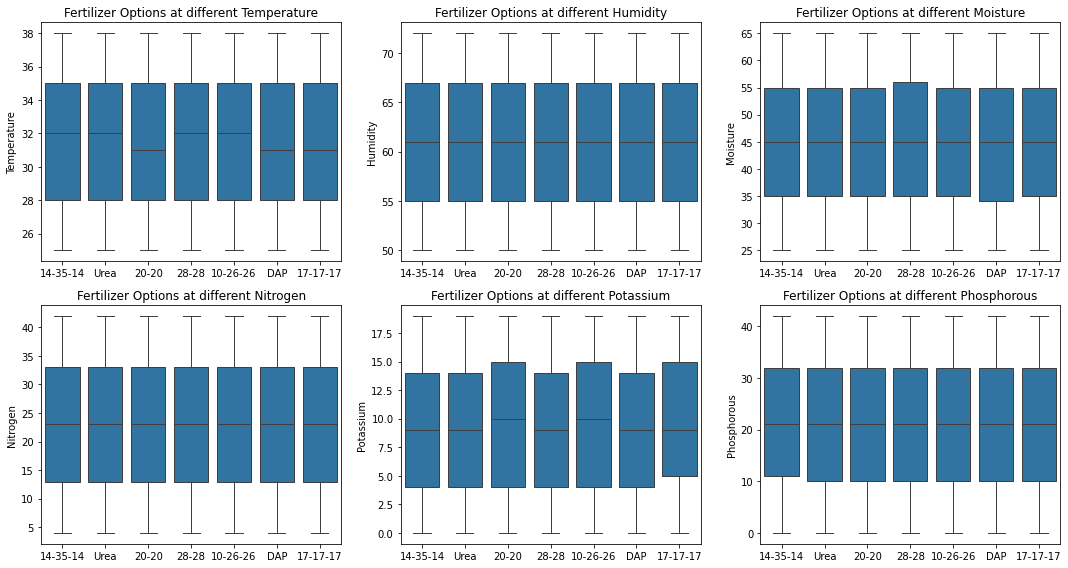

In [8]:
# Explore Numeric Relationships with Fertilizer Type
fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=col, x=target, data=data, ax=axes[i])
    axes[i].set_title('Fertilizer Options at different ' + col)
    axes[i].set_xlabel('')
plt.tight_layout()
plt.show()

Based on the boxplots above, no numeric feature alone has a clear relationship with `Fertilzer Name` - notably `Postassium` and `Temperature` have different medians depending on `Fertilzer Name`, but not a significant difference.

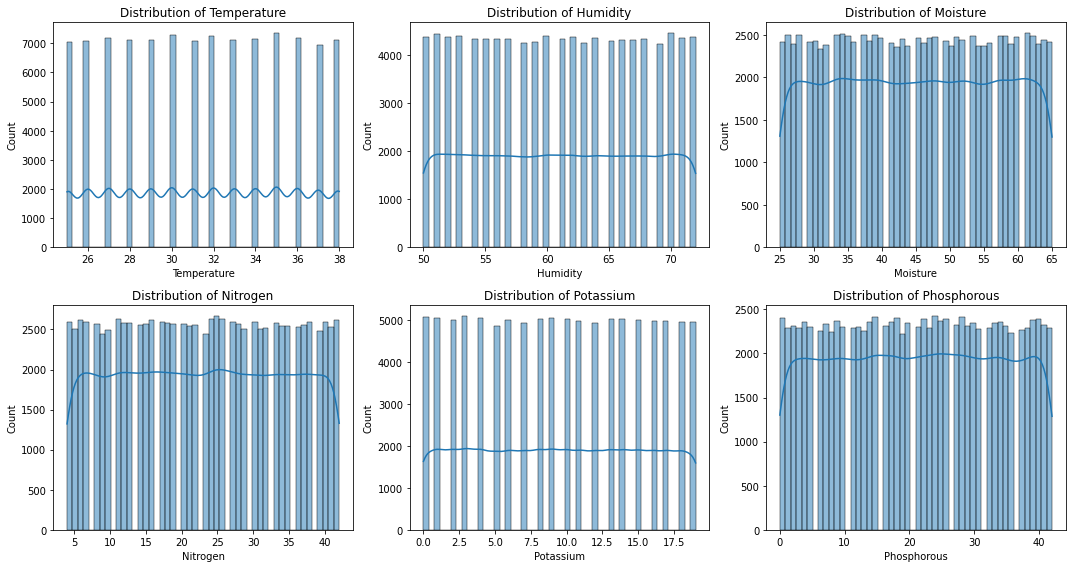

In [9]:
# Examine the distributions of the numeric features
fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(x=col, data=data, ax=axes[i], bins=50, kde=True)
    axes[i].set_title('Distribution of ' + col)
plt.tight_layout()
plt.show()

The numeric features do not display a normal distributions, so consider the underlying assumptions being used when modelling.

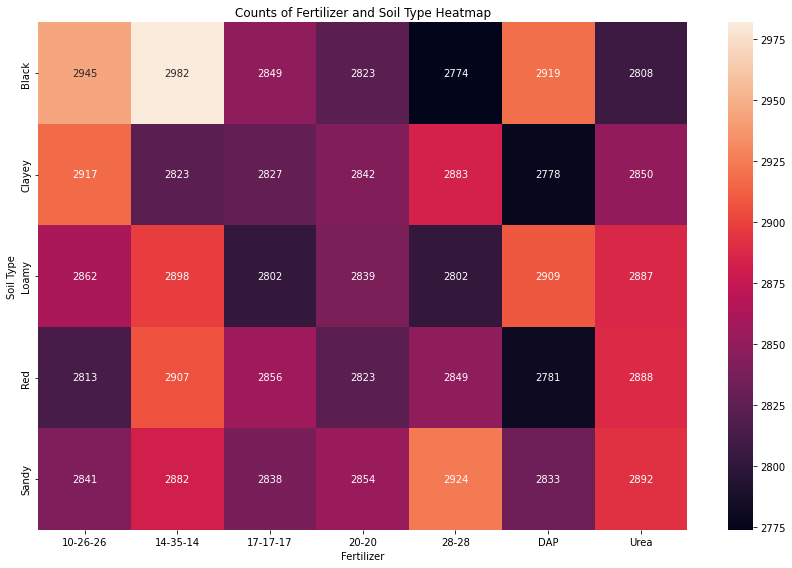

Fertilizer  10-26-26  14-35-14  17-17-17  20-20  28-28   DAP  Urea
Soil Type                                                         
Black           2945      2982      2849   2823   2774  2919  2808
Clayey          2917      2823      2827   2842   2883  2778  2850
Loamy           2862      2898      2802   2839   2802  2909  2887
Red             2813      2907      2856   2823   2849  2781  2888
Sandy           2841      2882      2838   2854   2924  2833  2892

Chi-Square Test of Independence p-value: 0.6107


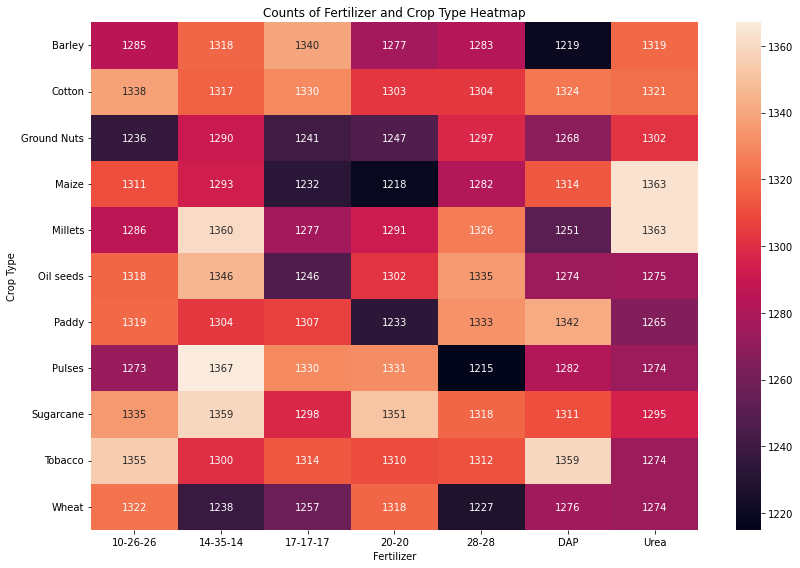

Fertilizer   10-26-26  14-35-14  17-17-17  20-20  28-28   DAP  Urea
Crop Type                                                          
Barley           1285      1318      1340   1277   1283  1219  1319
Cotton           1338      1317      1330   1303   1304  1324  1321
Ground Nuts      1236      1290      1241   1247   1297  1268  1302
Maize            1311      1293      1232   1218   1282  1314  1363
Millets          1286      1360      1277   1291   1326  1251  1363
Oil seeds        1318      1346      1246   1302   1335  1274  1275
Paddy            1319      1304      1307   1233   1333  1342  1265
Pulses           1273      1367      1330   1331   1215  1282  1274
Sugarcane        1335      1359      1298   1351   1318  1311  1295
Tobacco          1355      1300      1314   1310   1312  1359  1274
Wheat            1322      1238      1257   1318   1227  1276  1274

Chi-Square Test of Independence p-value: 0.3403


In [10]:
# Explore categorical relationships with Fertilizer Type
for col in cat_cols:
    # Compute the contingency table
    crosstab = pd.crosstab(index=data[col], columns=data['Fertilizer'])
    # Display the heatmaps
    plt.figure(figsize=(12, 8))
    sns.heatmap(crosstab, annot=True, fmt='d')
    plt.title('Counts of ' + target + ' and ' + col + ' Heatmap')
    plt.tight_layout()
    plt.show()
    print(crosstab)
    # Chi-Square Test
    chi2 = scipy.stats.chi2_contingency(crosstab)
    print('\nChi-Square Test of Independence p-value:', round(chi2.pvalue, 4))

The counts of different fertilzer types are different depending on the different soil and crop types; however, based on the chi-square test performed, these count results are not statistically significant and the null hypothesis of independence between the variables cannot be rejected.

## Preliminary Modelling

### Preparation

In [11]:
# Create a dictionary to map target labels to number
target_mapping = {
    '14-35-14':0, 
    'Urea':1, 
    '20-20':2, 
    '28-28':3, 
    '10-26-26':4, 
    'DAP':5,
    '17-17-17':6
}
# Create another dictionary to retrieve back the string target labels
target_unmapping = {number:fertilizer for fertilizer, number in target_mapping.items()}

In [12]:
# Include the numeric target labels to the dataset
data['Fertilizer_numeric'] = data['Fertilizer'].map(target_mapping)
target_numeric = 'Fertilizer_numeric'
data.head()

,Temperature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer,Fertilizer_numeric
0,32,51,41,Red,Ground Nuts,7,3,19,14-35-14,0
1,35,58,35,Black,Cotton,4,14,16,Urea,1
2,27,55,43,Sandy,Sugarcane,28,0,17,20-20,2
3,33,56,56,Loamy,Ground Nuts,37,5,24,28-28,3
4,32,70,60,Red,Ground Nuts,4,6,9,14-35-14,0


### Modelling Ideas for Multiclass Classification
List out some potential models for a multiclass classification problem:
1. Multinomial Logistic Regression
2. Decision Tree Classifier
3. Random Forest Classifier
4. Gradient Boosting (XGBoost)
5. k-NN
6. SVM
7. Naive Bayes
8. Perceptron

In [13]:
# Load the models from their pacakges
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC --> Takes too long to run
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

We will skip using the SVM model as it takes too long to run on even a small dataset.

### Model Evaluation

In [14]:
# Set a model seed
model_seed = 36209436

# Initialize model objects and set reasonable parameter values
logit = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', random_state=model_seed)
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=model_seed)
rf = RandomForestClassifier(n_estimators=300, max_depth=15, max_features='sqrt', random_state=model_seed)
xgb = XGBClassifier(n_estimators=500, max_depth=10, learning_rate=0.1, subsample=0.8, 
                    colsample_bytree=0.8, eval_metric='mlogloss', random_state=model_seed)
knn = KNeighborsClassifier(n_neighbors=14, weights='distance', metric='minkowski')
# svc = SVC(kernel='linear', random_state=model_seed) --> Takes too long to run
naive = GaussianNB()
perceptron = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                           alpha=0.001, learning_rate='adaptive', max_iter=1000, random_state=model_seed)
# Test an ensemble model
ensemble = VotingClassifier(
    estimators=[
        ('logit',logit),
        ('rf',rf),
        ('xbg',xgb),
        ('knn',knn),
        ('naive',naive),
        ('perceptron',perceptron)
    ],
    voting='soft',
    n_jobs=6 # Run the models in parallel
)

# Save a dictionary containing all the models to test
models = {'Logistic':logit, 'Decision Tree':dt, 'Random Forest':rf, 'XGBoost':xgb,
          'KNN':knn, 'Naive Bayes':naive, 'Perceptron':perceptron, 'Ensemble':ensemble}

In [15]:
# Split the data into a training and a test set
from sklearn.model_selection import train_test_split

features = numeric_cols + cat_cols

# Perform a training-test split on the data
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target_numeric], test_size=0.25, random_state=model_seed)

# Create a test set to add the prediction rankings to to see the results
test = pd.concat([X_test, y_test], axis=1)
test[target] = y_test.map(target_unmapping)
test.head()

,Temperature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous,Soil Type,Crop Type,Fertilizer_numeric,Fertilizer
69973,35,58,42,16,13,9,Sandy,Ground Nuts,4,10-26-26
72712,31,72,62,38,12,0,Loamy,Ground Nuts,3,28-28
45119,37,53,31,27,16,11,Red,Oil seeds,6,17-17-17
70978,27,54,30,8,18,41,Sandy,Pulses,6,17-17-17
62106,25,66,31,41,12,4,Clayey,Barley,4,10-26-26


In [16]:
# Evaluate the models' MAP@3 scores
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(transformers=[
        ('categorical', OneHotEncoder(drop='first'), cat_cols),
        ('numeric', StandardScaler(), numeric_cols)
    ]
)

# Initalize a dictionary to store the models in
map3_scores = {}

print('Model MAP@3 Scores')
print('------------------')
# Loop through, evaluate each model, and print the result
for name, choice in models.items():

    model = make_pipeline(preprocessor, choice)
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Get the ranking predictions from the model
    rankings3 = generate_model_rankings(model, X_test, target_unmapping)

    # Convert the rankings into a series
    ranking_series = pd.Series(list(row) for row in rankings3)
    ranking_series.index = test.index

    # Add the series to the test data
    test[name] = ranking_series

    # Compute the MAP@3 score for the rankings and add it to the dictionary
    map3_scores[name] = MAP3(labels=test[target], rankings=test[name])

    print(f'{name}: {map3_scores[name]:.6}')

Model MAP@3 Scores
------------------
Logistic: 0.263933
Decision Tree: 0.26234
Random Forest: 0.26282
XGBoost: 0.264227
KNN: 0.266953
Naive Bayes: 0.26122
Perceptron: 0.262867
Ensemble: 0.265167


All the models perform similarly. The best model scores are for the KNN, ensemble, and XGBoost models. Unfortunately, all the models perform quite closely to randomness; this task will be quite difficult and fine tuning will be necessary.

### Ranking Results on Test Set

In [17]:
# View the AP@3 scores for the ensemble model on the test set, and compare with true class label
test['AP@3'] = test.apply(lambda row: AP3(row[target], row['Ensemble']), axis=1)
test.head(15)

,Temperature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous,Soil Type,Crop Type,Fertilizer_numeric,Fertilizer,Logistic,Decision Tree,Random Forest,XGBoost,KNN,Naive Bayes,Perceptron,Ensemble,AP@3
69973,35,58,42,16,13,9,Sandy,Ground Nuts,4,10-26-26,"[20-20, 28-28, Urea]","[DAP, 28-28, 10-26-26]","[28-28, 20-20, Urea]","[10-26-26, 17-17-17, 28-28]","[28-28, 10-26-26, DAP]","[28-28, 20-20, Urea]","[28-28, 10-26-26, Urea]","[28-28, 10-26-26, 17-17-17]",0.500000
72712,31,72,62,38,12,0,Loamy,Ground Nuts,3,28-28,"[DAP, 20-20, 28-28]","[DAP, 28-28, 10-26-26]","[10-26-26, 28-28, DAP]","[14-35-14, 10-26-26, 28-28]","[14-35-14, 20-20, Urea]","[20-20, DAP, 14-35-14]","[28-28, Urea, 20-20]","[14-35-14, Urea, 20-20]",0.000000
45119,37,53,31,27,16,11,Red,Oil seeds,6,17-17-17,"[10-26-26, 14-35-14, 20-20]","[14-35-14, 10-26-26, DAP]","[28-28, 14-35-14, Urea]","[14-35-14, 28-28, 17-17-17]","[28-28, 17-17-17, Urea]","[14-35-14, 10-26-26, 20-20]","[28-28, 20-20, Urea]","[28-28, 14-35-14, 17-17-17]",0.333333
70978,27,54,30,8,18,41,Sandy,Pulses,6,17-17-17,"[17-17-17, 20-20, 14-35-14]","[14-35-14, DAP, 10-26-26]","[17-17-17, Urea, 28-28]","[14-35-14, 28-28, Urea]","[17-17-17, Urea, 20-20]","[20-20, 17-17-17, 14-35-14]","[20-20, 10-26-26, Urea]","[17-17-17, Urea, 20-20]",1.000000
62106,25,66,31,41,12,4,Clayey,Barley,4,10-26-26,"[17-17-17, 10-26-26, DAP]","[DAP, 28-28, 10-26-26]","[28-28, 20-20, DAP]","[28-28, 14-35-14, 20-20]","[10-26-26, 20-20, 28-28]","[10-26-26, 17-17-17, DAP]","[17-17-17, 10-26-26, DAP]","[28-28, 10-26-26, 20-20]",0.500000
28910,25,54,38,8,14,35,Red,Tobacco,5,DAP,"[17-17-17, Urea, 14-35-14]","[10-26-26, DAP, 28-28]","[DAP, Urea, 14-35-14]","[Urea, 28-28, 10-26-26]","[DAP, 14-35-14, 10-26-26]","[17-17-17, DAP, 28-28]","[20-20, 14-35-14, Urea]","[DAP, Urea, 28-28]",1.000000
95854,29,69,35,25,7,26,Loamy,Paddy,1,Urea,"[DAP, 17-17-17, 14-35-14]","[DAP, 28-28, 10-26-26]","[20-20, 17-17-17, 10-26-26]","[20-20, 17-17-17, Urea]","[17-17-17, 20-20, 10-26-26]","[17-17-17, DAP, 10-26-26]","[14-35-14, Urea, DAP]","[20-20, 17-17-17, 10-26-26]",0.000000
22179,38,56,34,4,3,19,Sandy,Maize,5,DAP,"[Urea, 14-35-14, 28-28]","[Urea, DAP, 14-35-14]","[17-17-17, 20-20, Urea]","[Urea, 17-17-17, 20-20]","[17-17-17, 20-20, 10-26-26]","[Urea, DAP, 28-28]","[10-26-26, 17-17-17, 28-28]","[Urea, 17-17-17, 20-20]",0.000000
18968,38,58,25,21,9,20,Clayey,Oil seeds,0,14-35-14,"[10-26-26, 14-35-14, 28-28]","[20-20, DAP, 14-35-14]","[DAP, 20-20, Urea]","[DAP, 28-28, 17-17-17]","[10-26-26, 28-28, Urea]","[10-26-26, 14-35-14, 28-28]","[10-26-26, Urea, 28-28]","[28-28, 10-26-26, DAP]",0.000000
78661,28,52,50,35,12,1,Red,Pulses,1,Urea,"[20-20, 17-17-17, 14-35-14]","[DAP, 28-28, 10-26-26]","[17-17-17, 10-26-26, 28-28]","[17-17-17, 10-26-26, 20-20]","[28-28, 17-17-17, 10-26-26]","[20-20, 17-17-17, 14-35-14]","[DAP, 10-26-26, 17-17-17]","[17-17-17, 10-26-26, 28-28]",0.000000


We can see we get lots of zero AP@3 scores. That means that the correct class label was not even contained in some of our prediction rankings.

## Conclusion

This data will be quite challenging to model as there is no clear good predictor and all the fertilizers display similar feature values. Due the importance of the categorical featues we found above, I would like to try out the CatBoost package for modelling on the competition data.